# Gesture model training

## Data Reading

This section reads the data from the sensors. The data is stored in two .csv files, Measurement.cs and Batch.csv <br>
Measurement.csv contains the actual values of rotation and acceleration. Each gesture has 100 tim

In [1]:
import pandas as pd

ms = pd.read_csv("measurement_db-Measurement.csv")
ms

,id,batchId,xRotation,yRotation,zRotation,xAcceleration,yAcceleration,zAcceleration
0,1,2,0.004261,0.004527,0.000533,0.319741,0.886541,9.669696
1,2,2,0.004261,0.004527,0.000533,0.307777,0.879362,9.731909
2,3,2,0.004261,0.004527,0.000533,0.269492,0.872184,9.748808
3,4,2,0.002397,0.002796,0.003196,0.348455,0.853041,9.767951
4,5,2,0.002397,0.002796,0.003196,0.331705,0.848256,9.765558
...,...,...,...,...,...,...,...,...
62095,62096,626,-0.259251,-0.094140,0.111317,-0.954736,0.929612,9.662517
62096,62097,626,-0.259251,-0.094140,0.111317,-1.026521,0.891326,9.686445
62097,62098,626,-0.259251,-0.094140,0.111317,-0.983450,0.699602,9.763165
62098,62099,626,-0.259251,-0.094140,0.111317,-0.923480,0.584746,9.808629


The Batch.csv contains the id of the batch and the type of the gesture: <br> 
0 -> Up and down <br>
1 -> Left and right <br>
2 -> Rotation

In [2]:
bt = pd.read_csv("measurement_db-Batch.csv")
bt

,id,type
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
621,622,2
622,623,2
623,624,2
624,625,2


## Data preparing

This section prepares the data in order to feed it to the neural network model. <br>
Firstly, we concatenate all the values from the table, and we will organise the data in two columns with gesture's type and it's 100 measures.

In [3]:
import numpy as np
data = pd.DataFrame(columns=['type', 'sensors'])
for i in set(ms['batchId'].tolist()):
    allMeasurements = ms.loc[ms['batchId'] == i]
    filtered = allMeasurements.drop('id', inplace=False, axis=1).drop('batchId', inplace=False, axis=1).to_numpy()
    flat = filtered.flatten()
    batchType = bt.loc[bt['id'] == i].iat[0,1]
    data.loc[len(data)] = {
    "type": batchType,
    "sensors": filtered
    }
data

,type,sensors
0,0,"[[0.0042609320953488, 0.0045272405259311, 0.00..."
1,0,"[[-0.0555252730846405, -0.0154458787292242, 0...."
2,0,"[[-0.0061250897124409, 0.0034620072692632, -0...."
3,0,"[[-0.0271634422242641, -0.0018641578499227, 0...."
4,0,"[[-0.0051930109038949, -0.0071903229691088, 0...."
...,...,...
616,2,"[[-0.0585878156125545, 0.0190410409122705, 0.0..."
617,2,"[[-0.1560566425323486, -0.0211715064942836, 0...."
618,2,"[[-0.026231363415718, 0.0113181006163358, 0.01..."
619,2,"[[-0.0013315412215888, 0.0091876350343227, 0.0..."


Now, we split the data into training and test.

In [4]:
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = np.stack(data['sensors'].values)
y = data['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test)
print(y_test)

[[[ 1.19838715e-02  1.58453416e-02 -1.86415785e-03  5.54536641e-01
   -5.38833737e-01  9.74387264e+00]
  [ 1.19838715e-02  1.58453416e-02 -1.86415785e-03  5.49750984e-01
   -4.31007177e-01  9.87323475e+00]
  [ 1.19838715e-02  1.58453416e-02 -1.86415785e-03  4.20389026e-01
   -4.57328230e-01  9.85648537e+00]
  ...
  [-8.92132614e-03 -2.74297502e-02 -8.25555623e-03  2.43021056e-01
   -1.04671037e+00  1.14975128e+01]
  [-8.92132614e-03 -2.74297502e-02 -8.25555623e-03  3.12562466e-01
   -3.06430846e-01  1.11022482e+01]
  [-8.92132614e-03 -2.74297502e-02 -8.25555623e-03  6.02393091e-01
   -4.35792834e-01  9.94516945e+00]]

 [[-2.78292131e-02 -4.79354849e-03 -1.58453416e-02 -5.28215587e-01
    6.72981367e-02  9.68405247e+00]
  [-2.78292131e-02 -4.79354849e-03 -1.58453416e-02 -4.66002196e-01
    4.93519660e-03  9.79187870e+00]
  [-2.78292131e-02 -4.79354849e-03 -1.58453416e-02 -4.01396006e-01
   -4.66899514e-01  1.01080303e+01]
  ...
  [-1.04925454e-01 -3.48863825e-02  1.33154128e-04 -1.71385

## Model training

This section covers the model training process.

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Flatten

import tensorflow as tf

model = Sequential()
model.add(Input(shape = (100,6)))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Flatten())
model.add(Dense(3, activation='softmax')) 

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(X_train, y_train, epochs=10, batch_size=40, validation_split=0.1)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4455 - loss: 2.2254 - val_accuracy: 0.5600 - val_loss: 0.7393
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7506 - loss: 0.4987 - val_accuracy: 0.9800 - val_loss: 0.1572
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9510 - loss: 0.1936 - val_accuracy: 0.9800 - val_loss: 0.0733
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9714 - loss: 0.0936 - val_accuracy: 1.0000 - val_loss: 0.0424
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0457 - val_accuracy: 1.0000 - val_loss: 0.0192
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.0256 - val_accuracy: 1.0000 - val_loss: 0.0127
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss:

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100, 20)        │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100, 5)         │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,246 (20.50 KB)

 Trainable params: 1,748 (6.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,498 (13.67 KB)

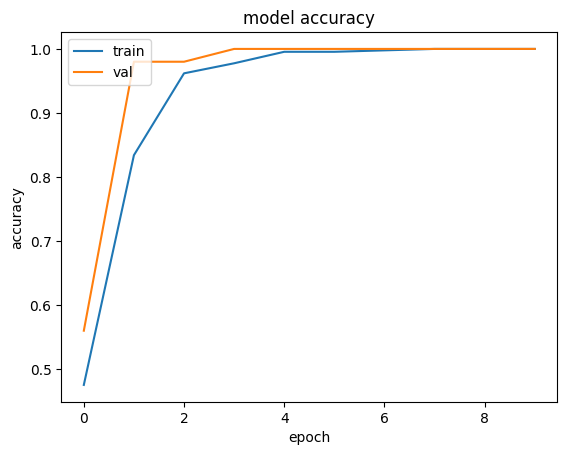

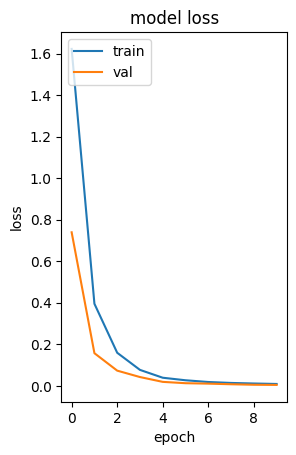

In [7]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.subplot(1,2,1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
loss, accuracy = model.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0093 


Training two predefined trees classifiers with the recorded data.

In [9]:
from sklearn.ensemble import RandomForestClassifier
X = np.array(data['sensors'].tolist())
y = np.array(data['type'])

X = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train, y_train)

accuracy = rfc.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 1.0


In [10]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics 

clf = DecisionTreeClassifier()

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.984


## Model exporting

This section is used to convert the keras model to a tensor flow lite model in order to be imported into the watch application.

In [11]:
import tensorflow as tf

# Save the model
model.save('temp_model.h5')

# Reload the model
temp = tf.keras.models.load_model('temp_model.h5', compile=False)

#converter = tf.lite.TFLiteConverter.from_keras_model(temp)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_100_6.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/n4/l9jzx91j5bj33w5yq7mv1mqw0000gn/T/tmpu8idkmc5/assets


INFO:tensorflow:Assets written to: /var/folders/n4/l9jzx91j5bj33w5yq7mv1mqw0000gn/T/tmpu8idkmc5/assets


Saved artifact at '/var/folders/n4/l9jzx91j5bj33w5yq7mv1mqw0000gn/T/tmpu8idkmc5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13164401616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13164402768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13164402384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13164403152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13164404496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13164405264: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739456571.880574  726981 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739456571.880735  726981 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-13 16:22:51.881091: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/n4/l9jzx91j5bj33w5yq7mv1mqw0000gn/T/tmpu8idkmc5
2025-02-13 16:22:51.881419: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-13 16:22:51.881427: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/n4/l9jzx91j5bj33w5yq7mv1mqw0000gn/T/tmpu8idkmc5
I0000 00:00:1739456571.884024  726981 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-02-13 16:22:51.884391: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-13 16:22:51.902320: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

In [12]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="model_100_6.tflite")
interpreter.allocate_tensors()

inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[  1 100   6] <class 'numpy.float32'>

1 output(s):
[1 3] <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
